# Import backage

In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from exp.sir.train import train
from models_new import Renorm_Dynamic
from exp.sir.dynamic_models_sis_new import Simple_Spring_Model
from ei.EI_calculation import EmergencePsi
from ei.EI_calculation import test_model_causal_multi_sis

from datetime import datetime
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Noise experiments

In [3]:
# nis+ CE macro
mul_batch_size = [0,5000,3000,1000]
sigma_list = [0.00001,0.0001,0.001,0.01,0.1,1]
experiments = len(sigma_list)
rou = -0.5
steps = 7
sz = 4
L = 1
mae2_w = 3
hidden_units = 64
T_total = 30001
dt = 0.01
spring = Simple_Spring_Model(device=device)

In [6]:
# nis+ micro
scale = 4
eis_micro_e = np.zeros([experiments,T_total//500+1])
losses_micro_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_micro_e = np.zeros([experiments,T_total//500+1])

for e in range(experiments)[1:]:
    sigma = sigma_list[e]
    seed = 1 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=0.01) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=0.01)
    
    eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp, net = train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, T2=T_total,framework='nis+')
    eis_micro_e[e,:] = eis_nisp
    losses_micro_e[e,:] = losses_nisp
    #MAEs_mstep_micro_e[e,:] = MAEs_mstep_nisp
    torch.save(net.state_dict(), 'mdl_data/micro noise = '+str(sigma)+'.mdl')

 54%|█████▍    | 1616/3001 [03:34<00:55, 24.88it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 11%|█         | 2999/27000 [15:17<2:02:18,  3.27it/s]


KeyboardInterrupt: 

In [ ]:
# nis+ macro
sigma_list = [0.00001, 0.0001,0.001,0.01,0.1,1]
experiments = len(sigma_list)
scale = 2
eis_macro_e = np.zeros([experiments,T_total//500+1])
losses_macro_e = np.zeros([experiments,T_total//500+1])
#MAEs_mstep_macro_e = np.zeros([experiments,T_total//500+1])
for e in range(experiments):
    sigma = sigma_list[e]
    seed = 1 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=0.01) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=0.01)
    
    eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp, net = train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, T2=T_total,framework='nis+')
    eis_macro_e[e,:] = eis_nisp
    losses_macro_e[e,:] = losses_nisp
    #MAEs_mstep_macro_e[e,:] = MAEs_mstep_nisp
    torch.save(net.state_dict(), 'mdl_data/macro noise = '+str(sigma)+'.mdl')

# Plot

In [7]:
sigma_list = [0.00001, 0.0001,0.001,0.01,0.1,1]
ce_list=[]
macro_list=[]
micro_list=[]
psi_list=[]
MAE_raw = torch.nn.L1Loss(reduction='none')
for sigma in sigma_list:
    spring_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) #sir
    s,sp,l,lp = spring_data
    net4 = Renorm_Dynamic(sym_size = sz, latent_size = 4, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)
    net2 = Renorm_Dynamic(sym_size = sz, latent_size = 2, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)
    net4.to(device=device)
    net2.to(device=device)
    net4.load_state_dict(torch.load('mdl_data/micro noise = '+str(sigma)+'.mdl', weights_only=True))
    net2.load_state_dict(torch.load('mdl_data/macro noise = '+str(sigma)+'.mdl', weights_only=True))
    _, _, V = net2.forward(s)
    psi, _, _ = EmergencePsi(s.cpu().numpy(), V.cpu().detach().numpy()) 
    ei4, sigmas0,weightsnet=test_model_causal_multi_sis(spring_data,MAE_raw,net4,sigma,4, L=L,num_samples = 1000)
    ei2, sigmas0,weightsnet=test_model_causal_multi_sis(spring_data,MAE_raw,net2,sigma,2, L=L,num_samples = 1000)
    ce_list.append(ei2[0]-ei4[0])
    macro_list.append(ei2[0])
    micro_list.append(ei4[0])
    psi_list.append(psi)

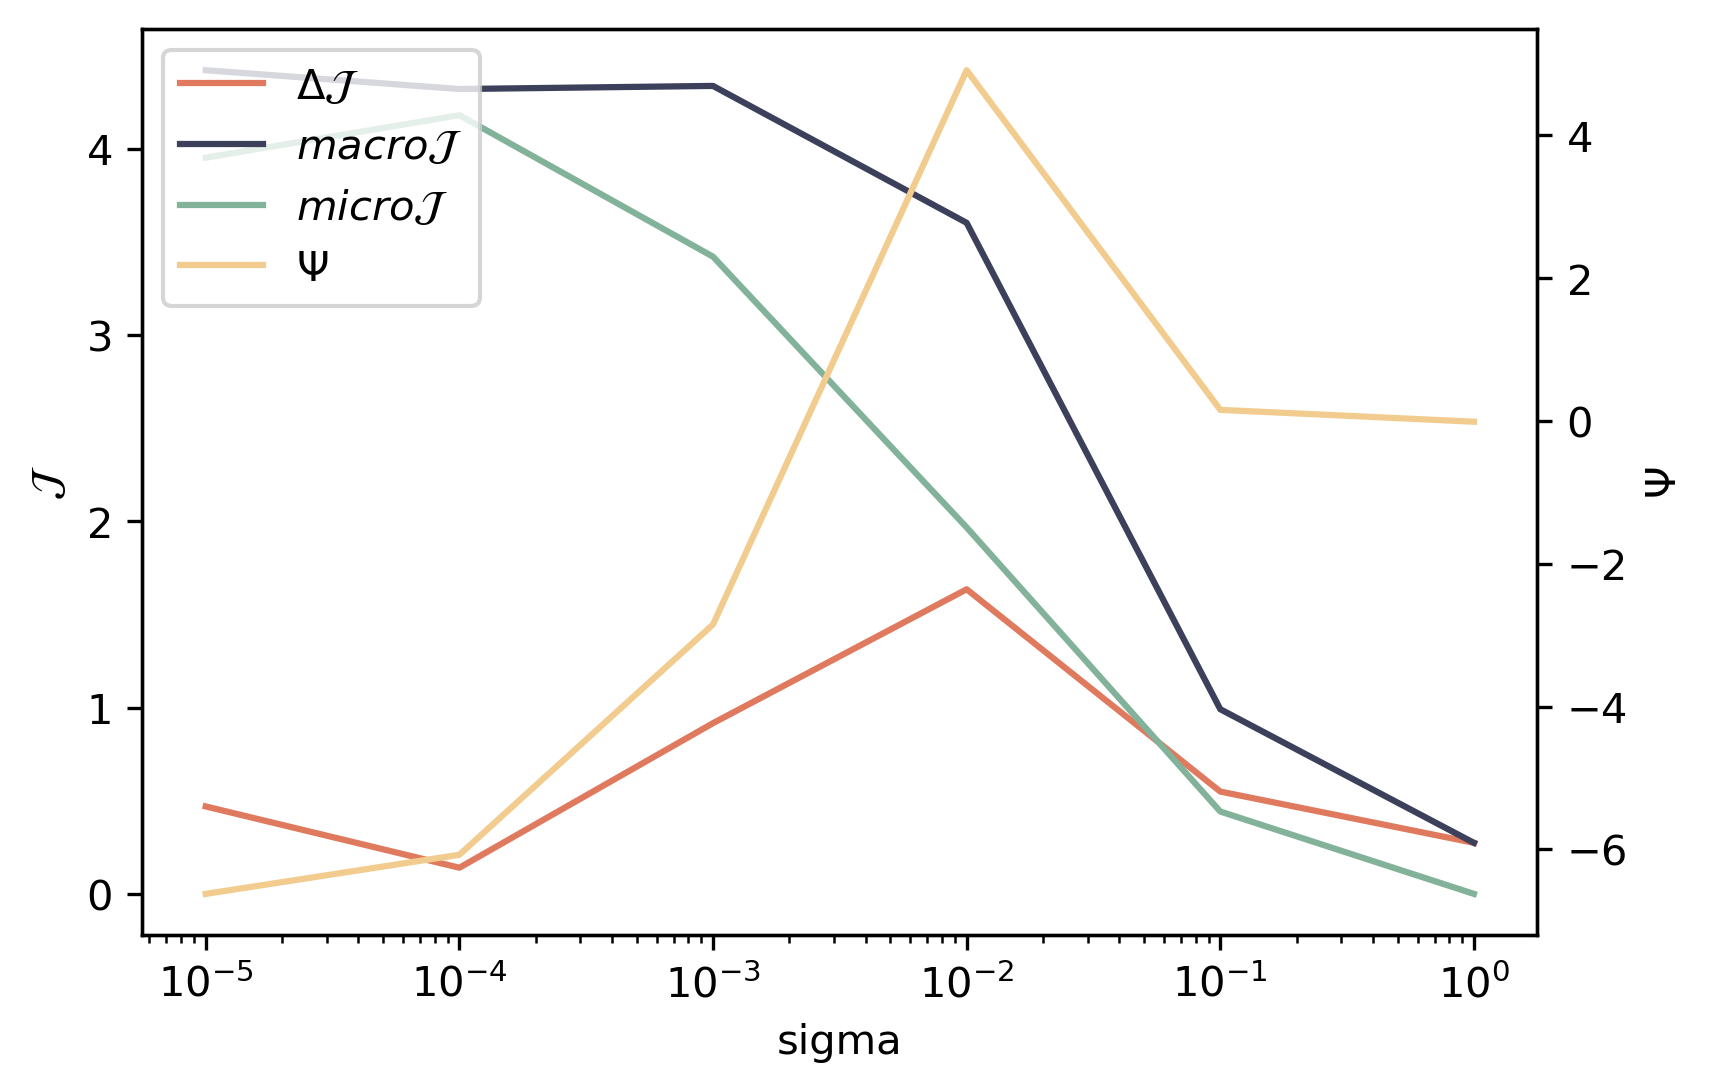

In [8]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
ax1 = plt.subplot(111)
plt.plot(sigma_list, ce_list,label = r'$\Delta \mathcal{J}$', color=color_label[1])
plt.plot(sigma_list, macro_list,label = r'$macro \mathcal{J}$', color=color_label[2])
plt.plot(sigma_list, micro_list,label = r'$micro \mathcal{J}$', color=color_label[3])
plt.xlabel("sigma")
plt.xscale('log')
plt.ylabel(r'$\mathcal{J}$')

ax2 = ax1.twinx()
plt.plot(sigma_list, psi_list,label = r'$\Psi$', color=color_label[4])
ax2.set_ylabel(r'$\Psi$')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()